# Geoword Testing Environment
For building multiple examples of geoword sequences

In [1]:
%load_ext autoreload
import pyvista as pv

from geogen.generation import *
import geogen.model as geo
import geogen.plot as geovis

pv.set_jupyter_backend("client")

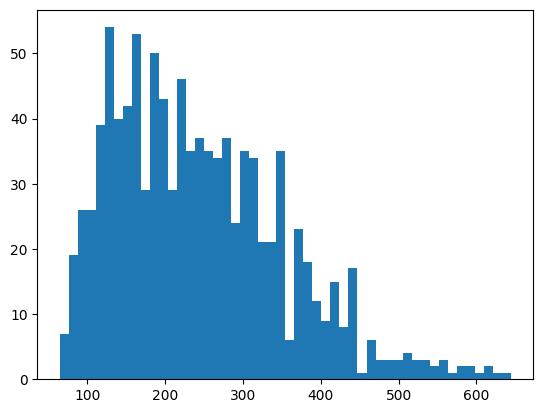

In [2]:
import geogen.probability as rv
import numpy as np
# Testing amplitude rv
n_samples = 1000
amps = np.zeros(n_samples)
for i in range(n_samples):
    amps[i] = rv.beta_min_max(1.8, 5.5, 60,800)
    
import matplotlib.pyplot as plt
plt.hist(amps, bins=50)
plt.show()

## Batch Viewer

In [3]:
%aimport geogen.generation.geowords
%aimport geogen.generation.categorical_events

# List of geological words to generate
sentence = [BaseStrata()]

# Model resolution and bounds
z = 64
res = (2*z, 2*z, z)
bounds = (BOUNDS_X, BOUNDS_Y, BOUNDS_Z) # Bounds imported from generation (geowords file)
# res = (z, z, z)
# bounds = ((-1920, 1920),(-1920, 1920),(-1920, 1920))
test_viewer = geovis.GeoWordPlotter(sentence, bounds, res, 9, clim = (0,13))

RuntimeError: No Qt binding was found, got: No Qt bindings could be found

## Single Viewer

In [ ]:
%load_ext autoreload
%autoreload 2

from geogen.generation import *

# set numpy seed
np.random.seed(0)

# List of geological words to generate
sentence = [BaseStrata(), Sediment(), Fold(), Sediment(), Erosion()]
# Model resolution and bounds
z = 64
res = (2*z, 2*z, z)
bounds = (BOUNDS_X, BOUNDS_Y, BOUNDS_Z) # Bounds imported from generation (geowords file)
# bounds = ((-1920, 1920),(-1920, 1920),(-1920, 1920))

def generate_model_func():
    hist = generate_history(sentence)
    model = geo.GeoModel(bounds=bounds, resolution=res)
    model.add_history(hist)
    model.compute_model(normalize=True)    
    
    return model

mr = geovis.ModelReviewer(generate_model_func, './')

mr.start_review()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Output()

## Forming New GeoWords

The contract for a geoword is that it simply needs to have a `build_ history()` function that will populate the `self.history` field.  For example we want to pair a fault with a dike randomly placed in the model. We can create a new `GeoWord` object that will encapsulate the random variables and the underlying processes. 

In [ ]:
from geogen.model import Fault, DikePlane
from geogen.probability import random_point_in_ellipsoid
import numpy as np


class MyFaultDikeWord(GeoWord):
    def build_history(self):
        bounds = ((-3840, 3840), (-3840, 3840), (-1920, 1920))
        strike = np.random.uniform(0, 360)
        dip = np.random.uniform(75, 90)
        rake = np.random.uniform(0, 360)
        origin = random_point_in_ellipsoid(bounds)
        # First a Fault
        fault_params = {
            "strike": strike,
            "dip": dip,
            "rake": rake,
            "amplitude": np.random.lognormal(0, 0.25) * 200,
            "origin": origin,
        }
        fault = Fault(**fault_params)
        # Then a Dike in the same area
        dike_params = {
            "strike": strike,
            "dip": dip,
            "width": np.random.normal(150, 50),
            "origin": origin,
        }
        dike = DikePlane(**dike_params)

        self.add_process(fault)
        self.add_process(dike)
        # No return value needed

Now adding a new `GeoWord` object that encapsulates the fault and dike processes. To a sentence:

In [ ]:
sentence = [
    InfiniteBasement(),
    CoarseRepeatSediment(),
    FourierFold(),
    SingleRandSediment(),
    FineRepeatSediment(),
    MyFaultDikeWord(),
]

# Save directory for models
DEFAULT_BASE_DIR = "../saved_models"

# Model resolution and bounds
res = (256, 256, 128)
bounds = ((-3840, 3840), (-3840, 3840), (-1920, 1920))


def generate_model():
    # Generate a randomized history from geowords, one single sample
    hist = generate_history(sentence)
    model = geo.GeoModel(bounds=bounds, resolution=res)
    model.add_history(hist)
    model.compute_model(normalize=True)
    return model


reviewer = geovis.ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()